<a href="https://colab.research.google.com/github/Kazi-Rakib-Hasan-Jawwad/fMRI_Project/blob/main/ARIN0707_final_project_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Change the Colab setting as below before running** <br>
**Runtime --> Change Runtime Type --> Hardware accelerator: T4 GPU**

Lightweight 3‑D Vision Transformer + Masked‑Autoencoder (MAE) for fMRI
=====================================================================
Clean Colab‑ready script that:
• Loads the HCP_emotion_4D_sample.mat set (pre‑split 3200/800)
• Self‑supervised MAE pre‑trains a ViT encoder on 3‑D patches
• Fine‑tunes the encoder for binary Face vs Shape classification

Author: Kazi Rakib Hasan

Student ID: 2022427248


Licence: CC BY-NC 4.0

In [19]:
import os, sys, math, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [20]:
# --- FIX for Circular Import Error in some Pytorch/Colab versions ---
# Disabling torch.compile to avoid an error.
if hasattr(torch, 'compiler'):
    torch.compiler.disable()

In [3]:
# ----------------------------------------------------
# Setup and Configuration
# ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [21]:
# ----------------------------------------------------
# Mount Google drive
# ----------------------------------------------------

from google.colab import drive

drive.mount('/content/drive')
gdrive_dir = 'ARIN0707_project'

if not os.path.exists('/content/drive/My Drive/' + gdrive_dir):
  os.makedirs('/content/drive/My Drive/' + gdrive_dir)

os.chdir('/content/drive/My Drive/' + gdrive_dir)

data_path = '/content/drive/My Drive/' + gdrive_dir

ROOT = '/content/drive/My Drive/' + gdrive_dir
os.chdir(ROOT)

print(f"Project root: {ROOT}")

# Always‑valid directory for saving checkpoints
SAVE_DIR = ROOT if os.path.isdir(ROOT) else os.getcwd()

print(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/My Drive/ARIN0707_project
/content/drive/My Drive/ARIN0707_project


In [5]:
# ----------------------------------------------------
# Download dataset
# ----------------------------------------------------

if not os.path.exists(data_path + '/HCP_emotion_4D_sample.mat'):
  !pip install pydrive
  print('\n\n')
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  gdrive = GoogleDrive(gauth)

  # Download the data with Google Drive link
  # Download takes about 5 mins.
  img_file = gdrive.CreateFile({'id':'1OZQW_KkOsn_3-CsLHB018T_3V3huGB7E'})
  img_file.GetContentFile(data_path + '/HCP_emotion_4D_sample.mat')

In [6]:
# ----------------------------------------------------
# Load Data from Google Drive
# ----------------------------------------------------

data = loadmat(data_path + '/HCP_emotion_4D_sample.mat')

# Train: 3200, Test: 800
# Report your model's performance only on designated testset (800 samples)
# You are not allowed to mix data samples between the predefined train / test datasets.

X_train = data['X_train']
y_train = data['y_train']
ids_train = data['ids_train']

X_test = data['X_test']
y_test = data['y_test']
ids_test = data['ids_test']

del data
# Check data shape

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('ids_train shape: ', ids_train.shape)

print('\n')

print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('ids_test shape: ', ids_test.shape)

X_train shape:  (3200, 53, 63, 46)
y_train shape:  (3200, 1)
ids_train shape:  (3200,)


X_test shape:  (800, 53, 63, 46)
y_test shape:  (800, 1)
ids_test shape:  (800,)


In [7]:
# Custom Dataset Class

class DynamicFMRI_Dataset(Dataset):
    def __init__(self, X, y, augment_ratio=0.0, normalize=False):
        self.X_original = torch.from_numpy(X).float()
        self.y_original = torch.from_numpy(y).long()
        self.normalize = normalize

        self.original_size = len(self.X_original)
        self.do_augment = augment_ratio > 0
        self.augmentation_indices = None

        if self.do_augment:
            self.num_to_augment = int(self.original_size * augment_ratio)
            all_indices = np.arange(self.original_size)
            np.random.shuffle(all_indices)
            self.augmentation_indices = torch.from_numpy(all_indices[:self.num_to_augment])
            print(f"Created dataset with {self.num_to_augment} on-the-fly augmented samples.")


    def __len__(self):
        return self.original_size + self.num_to_augment if self.do_augment else self.original_size

    def __getitem__(self, idx):
        if not self.do_augment or idx < self.original_size:
            x_item = self.X_original[idx]
            y_item = self.y_original[idx]
        else:
            # This check ensures self.augmentation_indices is not None before subscripting
            if self.augmentation_indices is not None:
                mapped_idx = self.augmentation_indices[idx - self.original_size]
                x_item = self.X_original[mapped_idx]
                y_item = self.y_original[mapped_idx]
                x_item = torch.flip(x_item, dims=[-1])
            else:
                # This case should not be reached with the corrected __init__
                raise RuntimeError("Augmentation indices are not initialized!")


        if self.normalize:
            mean = x_item.mean()
            std = x_item.std()
            if std > 1e-6:
                x_item = (x_item - mean) / std
        return x_item, y_item

In [8]:
# Dataloader

batch_size = 8
train_dataset = DynamicFMRI_Dataset(X_train, y_train, augment_ratio=0.1, normalize=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_dataset  = DynamicFMRI_Dataset(X_test,  y_test, augment_ratio=0.0, normalize=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

_, img_depth, img_height, img_width = X_train.shape
del X_train, y_train, X_test, y_test

Created dataset with 320 on-the-fly augmented samples.


#**Main Model**

In [9]:
# ----------------------------------------------------
# 2D Patch Embedding for spatial slices
# ----------------------------------------------------

class PatchEmbedding2D(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model):
        super().__init__()
        self.img_h, self.img_w = img_size
        self.ph, self.pw = patch_size
        self.num_patches = (self.img_h // self.ph) * (self.img_w // self.pw)

        self.proj = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, d_model))
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.02)

    def forward(self, x): # x: (B, C, H, W)
        x = self.proj(x).flatten(2).transpose(1, 2) # (B, N, d_model)
        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, x), 1) + self.pos_embed
        return x # (B, N+1, d_model)

In [10]:
# ----------------------------------------------------
# Transformer Encoder / Decoder
# ----------------------------------------------------

# ViT Encoder for Spatial Feature Extraction
class ViTEncoder(nn.Module):
    def __init__(self, d_model, n_layers, nhead, dropout):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, n_layers)
    def forward(self, x):
        return self.encoder(x)

# Temporal Transformer
class TemporalTransformer(nn.Module):
    def __init__(self, d_model, n_layers, nhead, dropout):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model * 2, dropout, batch_first=True, norm_first=True)
        self.tfl = nn.TransformerEncoder(layer, n_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x): # x: (B, T, D) where T is sequence length
        return self.norm(self.tfl(x))


# MAE Decoder for 2D Patches
class MAEDecoder2D(nn.Module):
    def __init__(self, d_model, patch_dim, n_layers, nhead, dropout):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model * 2, dropout, batch_first=True)
        self.decoder = nn.TransformerEncoder(layer, n_layers)
        self.out = nn.Linear(d_model, patch_dim)
    def forward(self, x):
        return self.out(self.decoder(x))

In [11]:
# ----------------------------------------------------
# Masked Autoencoder
# ----------------------------------------------------
class MAEforSlices(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model, n_enc, n_dec, nhead, dropout, mask_ratio):
        super().__init__()
        self.patch_embed = PatchEmbedding2D(img_size, patch_size, in_channels, d_model)
        self.encoder = ViTEncoder(d_model, n_enc, nhead, dropout)
        self.mask_ratio = mask_ratio
        self.d_model = d_model
        self.N = self.patch_embed.num_patches
        self.patch_dim = int(np.prod(patch_size) * in_channels)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.decoder = MAEDecoder2D(d_model, self.patch_dim, n_layers=n_dec, nhead=nhead, dropout=dropout)

        # Create and initialize a positional embedding for the decoder
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.N, d_model))
        nn.init.normal_(self.decoder_pos_embed, std=0.02)
        nn.init.normal_(self.mask_token, std=0.02)


    def forward_loss(self, pred, target, mask):
        mean = target.mean(dim=-1, keepdim=True)
        var = target.var(dim=-1, keepdim=True)
        target = (target - mean) / (var + 1.e-6)**.5
        target_masked = target.gather(1, mask.unsqueeze(-1).expand(-1, -1, self.patch_dim))
        pred_masked = pred.gather(1, mask.unsqueeze(-1).expand(-1, -1, self.patch_dim))
        return F.mse_loss(pred_masked, target_masked)

    def forward(self, x_2d):
        B, H, W = x_2d.shape
        x = x_2d.unsqueeze(1)
        seq = self.patch_embed(x)
        cls, patches = seq[:, :1], seq[:, 1:]
        with torch.no_grad():
            target_patches = x.unfold(2, self.patch_embed.ph, self.patch_embed.ph).unfold(3, self.patch_embed.pw, self.patch_embed.pw)
            target_patches = target_patches.contiguous().view(B, -1, self.patch_dim)
        num_mask = int(self.N * self.mask_ratio)
        ids_shuffle = torch.rand(B, self.N, device=x.device).argsort(dim=1)
        ids_restore = ids_shuffle.argsort(dim=1)
        ids_mask = ids_shuffle[:, :num_mask]
        ids_keep = ids_shuffle[:, num_mask:]
        patches_keep = patches.gather(1, ids_keep.unsqueeze(-1).expand(-1, -1, self.d_model))
        enc_in = torch.cat([cls, patches_keep], 1)
        enc_out = self.encoder(enc_in)
        mask_tokens = self.mask_token.expand(B, num_mask, -1)
        dec_in_full = torch.cat([enc_out[:, 1:], mask_tokens], 1)
        dec_in = dec_in_full.gather(1, ids_restore.unsqueeze(-1).expand(-1, -1, self.d_model))

        # Add the decoder positional embedding to the decoder input
        recon = self.decoder(dec_in + self.decoder_pos_embed)
        return self.forward_loss(recon, target_patches, ids_mask)

In [12]:
# ----------------------------------------------------
# Spatio-Temporal Classifier
# ----------------------------------------------------
class SpatioTemporalClassifier(nn.Module):
    def __init__(self, img_size, time_steps, patch_size, in_channels, d_model,
                 n_spatial_enc, n_temporal_enc, nhead_spatial, nhead_temporal, dropout, n_classes):
        super().__init__()
        self.d_model = d_model
        # 1. Spatial Encoder (processes each slice)
        self.patch_embed = PatchEmbedding2D(img_size, patch_size, in_channels, d_model)
        self.spatial_encoder = ViTEncoder(d_model, n_spatial_enc, nhead_spatial, dropout)
        # 2. Temporal Encoder (processes sequence of slice representations)
        # Adding temporal positional embedding
        self.temporal_pos_embed = nn.Parameter(torch.zeros(1, time_steps, d_model))
        nn.init.normal_(self.temporal_pos_embed, std=0.02)
        self.temporal_encoder = TemporalTransformer(d_model, n_temporal_enc, nhead_temporal, dropout)
        # 3. Predictor
        self.predictor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, n_classes)
        )

    def forward(self, x): # x: (B, D, H, W)
        B, D, H, W = x.shape
        x_slices = x.view(B * D, H, W).unsqueeze(1) # -> (B*D, 1, H, W)

        # Spatial encoding for each slice
        spatial_seq = self.patch_embed(x_slices)    # (B*D, N_2d+1, d)
        spatial_out = self.spatial_encoder(spatial_seq) # (B*D, N_2d+1, d)
        slice_repr = spatial_out[:, 0]              # Get CLS token -> (B*D, d)

        # Form temporal sequence
        temporal_seq = slice_repr.view(B, D, self.d_model) # -> (B, D, d)
        temporal_seq += self.temporal_pos_embed # Add temporal pos encoding

        # Temporal encoding
        temporal_out = self.temporal_encoder(temporal_seq) # -> (B, D, d)

        # Predictor: Mean pool over time dimension
        pooled_out = temporal_out.mean(dim=1) # -> (B, d)
        logits = self.predictor(pooled_out)
        return logits

In [13]:
# ----------------------------------------------------
# Hyperparameters
# ----------------------------------------------------
# Architectural params
patch_size_2d = (7, 2) #
d_model    = 192
n_spatial_enc = 4
n_dec_mae = 2
n_temporal_enc = 2

# Spatial and temporal components
nhead_spatial = 8
nhead_temporal = 8

# Training params
dropout    = 0.1
mask_ratio = 0.65
num_classes= 2
mae_epochs = 100
clf_epochs = 20
mae_lr     = 1.5e-3
clf_lr     = 3e-4
warmup_epochs = 5

In [14]:
# ----------------------------------------------------
# Pre‑train MAE
# ----------------------------------------------------
print("\n--- Starting MAE Pre-training on 2D Slices ---")
mae = MAEforSlices(
    (img_height, img_width), patch_size_2d, 1, d_model,
    n_spatial_enc, n_dec_mae, nhead_spatial, dropout, mask_ratio
).to(device)

opt_mae = optim.AdamW(mae.parameters(), lr=mae_lr, betas=(0.9, 0.95), weight_decay=0.05)

def get_lr(it, total_it, warmup_it):
    if it < warmup_it:
        return mae_lr * it / warmup_it
    if it > total_it:
        return 1e-6
    decay_ratio = (it - warmup_it) / (total_it - warmup_it)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return 1e-6 + coeff * (mae_lr - 1e-6)

scaler = GradScaler(enabled=(device.type == 'cuda'))
total_iterations = mae_epochs * len(train_loader)
warmup_iterations = warmup_epochs * len(train_loader)
it_num = 0

mae_losses = []

for ep in range(mae_epochs):
    mae.train()
    total_loss = 0
    lr = 0.0
    pbar = tqdm(train_loader, desc=f"MAE Ep {ep+1}/{mae_epochs}")
    for imgs, _ in pbar:
        lr = get_lr(it_num, total_iterations, warmup_iterations)
        for param_group in opt_mae.param_groups:
            param_group['lr'] = lr
        imgs = imgs.to(device)
        slices = imgs.view(-1, img_height, img_width)
        opt_mae.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type == 'cuda')):
            loss = mae(slices)
        scaler.scale(loss).backward()
        scaler.step(opt_mae)
        scaler.update()
        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item(), lr=lr)
        it_num += 1

    avg_loss = total_loss / len(train_loader)
    mae_losses.append(avg_loss)
    print(f"MAE Epoch {ep+1}/{mae_epochs} | Avg Loss: {avg_loss:.4f} | Final LR: {lr:.2e}")

print("MAE pre-training done.\n")


--- Starting MAE Pre-training on 2D Slices ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/tmp/ipython-input-14-1301020322.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == 'cuda'))
MAE Ep 1/100:   0%|          | 0/440 [00:00<?, ?it/s]/tmp/ipython-input-14-1301020322.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
MAE Ep 1/100: 100%|██████████| 440/440 [01:42<00:00,  4.28it/s, loss=0.4, lr=0.000299]


MAE Epoch 1/100 | Avg Loss: 0.4193 | Final LR: 2.99e-04


MAE Ep 2/100: 100%|██████████| 440/440 [01:41<00:00,  4.34it/s, loss=0.395, lr=0.000599]


MAE Epoch 2/100 | Avg Loss: 0.3968 | Final LR: 5.99e-04


MAE Ep 3/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.394, lr=0.000899]


MAE Epoch 3/100 | Avg Loss: 0.3953 | Final LR: 8.99e-04


MAE Ep 4/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.391, lr=0.0012]


MAE Epoch 4/100 | Avg Loss: 0.3920 | Final LR: 1.20e-03


MAE Ep 5/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.374, lr=0.0015]


MAE Epoch 5/100 | Avg Loss: 0.3845 | Final LR: 1.50e-03


MAE Ep 6/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.339, lr=0.0015]


MAE Epoch 6/100 | Avg Loss: 0.3630 | Final LR: 1.50e-03


MAE Ep 7/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.289, lr=0.0015]


MAE Epoch 7/100 | Avg Loss: 0.3087 | Final LR: 1.50e-03


MAE Ep 8/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.263, lr=0.0015]


MAE Epoch 8/100 | Avg Loss: 0.2752 | Final LR: 1.50e-03


MAE Ep 9/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.256, lr=0.00149]


MAE Epoch 9/100 | Avg Loss: 0.2607 | Final LR: 1.49e-03


MAE Ep 10/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.247, lr=0.00149]


MAE Epoch 10/100 | Avg Loss: 0.2526 | Final LR: 1.49e-03


MAE Ep 11/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.249, lr=0.00149]


MAE Epoch 11/100 | Avg Loss: 0.2465 | Final LR: 1.49e-03


MAE Ep 12/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.251, lr=0.00148]


MAE Epoch 12/100 | Avg Loss: 0.2419 | Final LR: 1.48e-03


MAE Ep 13/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.239, lr=0.00147]


MAE Epoch 13/100 | Avg Loss: 0.2382 | Final LR: 1.47e-03


MAE Ep 14/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.228, lr=0.00147]


MAE Epoch 14/100 | Avg Loss: 0.2349 | Final LR: 1.47e-03


MAE Ep 15/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.228, lr=0.00146]


MAE Epoch 15/100 | Avg Loss: 0.2318 | Final LR: 1.46e-03


MAE Ep 16/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.227, lr=0.00145]


MAE Epoch 16/100 | Avg Loss: 0.2291 | Final LR: 1.45e-03


MAE Ep 17/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.225, lr=0.00144]


MAE Epoch 17/100 | Avg Loss: 0.2267 | Final LR: 1.44e-03


MAE Ep 18/100: 100%|██████████| 440/440 [01:39<00:00,  4.42it/s, loss=0.218, lr=0.00143]


MAE Epoch 18/100 | Avg Loss: 0.2245 | Final LR: 1.43e-03


MAE Ep 19/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.236, lr=0.00142]


MAE Epoch 19/100 | Avg Loss: 0.2226 | Final LR: 1.42e-03


MAE Ep 20/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.212, lr=0.00141]


MAE Epoch 20/100 | Avg Loss: 0.2207 | Final LR: 1.41e-03


MAE Ep 21/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.225, lr=0.0014]


MAE Epoch 21/100 | Avg Loss: 0.2190 | Final LR: 1.40e-03


MAE Ep 22/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.222, lr=0.00138]


MAE Epoch 22/100 | Avg Loss: 0.2172 | Final LR: 1.38e-03


MAE Ep 23/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.214, lr=0.00137]


MAE Epoch 23/100 | Avg Loss: 0.2159 | Final LR: 1.37e-03


MAE Ep 24/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.212, lr=0.00136]


MAE Epoch 24/100 | Avg Loss: 0.2144 | Final LR: 1.36e-03


MAE Ep 25/100: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.216, lr=0.00134]


MAE Epoch 25/100 | Avg Loss: 0.2133 | Final LR: 1.34e-03


MAE Ep 26/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.217, lr=0.00133]


MAE Epoch 26/100 | Avg Loss: 0.2121 | Final LR: 1.33e-03


MAE Ep 27/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.209, lr=0.00131]


MAE Epoch 27/100 | Avg Loss: 0.2108 | Final LR: 1.31e-03


MAE Ep 28/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.204, lr=0.00129]


MAE Epoch 28/100 | Avg Loss: 0.2100 | Final LR: 1.29e-03


MAE Ep 29/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.215, lr=0.00128]


MAE Epoch 29/100 | Avg Loss: 0.2091 | Final LR: 1.28e-03


MAE Ep 30/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.204, lr=0.00126]


MAE Epoch 30/100 | Avg Loss: 0.2079 | Final LR: 1.26e-03


MAE Ep 31/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.199, lr=0.00124]


MAE Epoch 31/100 | Avg Loss: 0.2072 | Final LR: 1.24e-03


MAE Ep 32/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.203, lr=0.00122]


MAE Epoch 32/100 | Avg Loss: 0.2063 | Final LR: 1.22e-03


MAE Ep 33/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.201, lr=0.0012]


MAE Epoch 33/100 | Avg Loss: 0.2058 | Final LR: 1.20e-03


MAE Ep 34/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.216, lr=0.00118]


MAE Epoch 34/100 | Avg Loss: 0.2048 | Final LR: 1.18e-03


MAE Ep 35/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.212, lr=0.00116]


MAE Epoch 35/100 | Avg Loss: 0.2042 | Final LR: 1.16e-03


MAE Ep 36/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.2, lr=0.00114]


MAE Epoch 36/100 | Avg Loss: 0.2035 | Final LR: 1.14e-03


MAE Ep 37/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.207, lr=0.00112]


MAE Epoch 37/100 | Avg Loss: 0.2029 | Final LR: 1.12e-03


MAE Ep 38/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.203, lr=0.0011]


MAE Epoch 38/100 | Avg Loss: 0.2025 | Final LR: 1.10e-03


MAE Ep 39/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.204, lr=0.00107]


MAE Epoch 39/100 | Avg Loss: 0.2018 | Final LR: 1.07e-03


MAE Ep 40/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.194, lr=0.00105]


MAE Epoch 40/100 | Avg Loss: 0.2011 | Final LR: 1.05e-03


MAE Ep 41/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.2, lr=0.00103]


MAE Epoch 41/100 | Avg Loss: 0.2007 | Final LR: 1.03e-03


MAE Ep 42/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.203, lr=0.00101]


MAE Epoch 42/100 | Avg Loss: 0.2000 | Final LR: 1.01e-03


MAE Ep 43/100: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.194, lr=0.000982]


MAE Epoch 43/100 | Avg Loss: 0.1994 | Final LR: 9.82e-04


MAE Ep 44/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.197, lr=0.000958]


MAE Epoch 44/100 | Avg Loss: 0.1988 | Final LR: 9.58e-04


MAE Ep 45/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.202, lr=0.000935]


MAE Epoch 45/100 | Avg Loss: 0.1986 | Final LR: 9.35e-04


MAE Ep 46/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.191, lr=0.00091]


MAE Epoch 46/100 | Avg Loss: 0.1982 | Final LR: 9.10e-04


MAE Ep 47/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.195, lr=0.000886]


MAE Epoch 47/100 | Avg Loss: 0.1976 | Final LR: 8.86e-04


MAE Ep 48/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.197, lr=0.000862]


MAE Epoch 48/100 | Avg Loss: 0.1971 | Final LR: 8.62e-04


MAE Ep 49/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.201, lr=0.000837]


MAE Epoch 49/100 | Avg Loss: 0.1967 | Final LR: 8.37e-04


MAE Ep 50/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.202, lr=0.000812]


MAE Epoch 50/100 | Avg Loss: 0.1964 | Final LR: 8.12e-04


MAE Ep 51/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.207, lr=0.000788]


MAE Epoch 51/100 | Avg Loss: 0.1959 | Final LR: 7.88e-04


MAE Ep 52/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.201, lr=0.000763]


MAE Epoch 52/100 | Avg Loss: 0.1955 | Final LR: 7.63e-04


MAE Ep 53/100: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.191, lr=0.000738]


MAE Epoch 53/100 | Avg Loss: 0.1952 | Final LR: 7.38e-04


MAE Ep 54/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.191, lr=0.000713]


MAE Epoch 54/100 | Avg Loss: 0.1945 | Final LR: 7.13e-04


MAE Ep 55/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.193, lr=0.000689]


MAE Epoch 55/100 | Avg Loss: 0.1944 | Final LR: 6.89e-04


MAE Ep 56/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.202, lr=0.000664]


MAE Epoch 56/100 | Avg Loss: 0.1939 | Final LR: 6.64e-04


MAE Ep 57/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.194, lr=0.000639]


MAE Epoch 57/100 | Avg Loss: 0.1936 | Final LR: 6.39e-04


MAE Ep 58/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.193, lr=0.000615]


MAE Epoch 58/100 | Avg Loss: 0.1931 | Final LR: 6.15e-04


MAE Ep 59/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.193, lr=0.000591]


MAE Epoch 59/100 | Avg Loss: 0.1928 | Final LR: 5.91e-04


MAE Ep 60/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.187, lr=0.000567]


MAE Epoch 60/100 | Avg Loss: 0.1923 | Final LR: 5.67e-04


MAE Ep 61/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.186, lr=0.000543]


MAE Epoch 61/100 | Avg Loss: 0.1920 | Final LR: 5.43e-04


MAE Ep 62/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.192, lr=0.000519]


MAE Epoch 62/100 | Avg Loss: 0.1917 | Final LR: 5.19e-04


MAE Ep 63/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.191, lr=0.000496]


MAE Epoch 63/100 | Avg Loss: 0.1914 | Final LR: 4.96e-04


MAE Ep 64/100: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.187, lr=0.000472]


MAE Epoch 64/100 | Avg Loss: 0.1910 | Final LR: 4.72e-04


MAE Ep 65/100: 100%|██████████| 440/440 [01:42<00:00,  4.30it/s, loss=0.195, lr=0.000449]


MAE Epoch 65/100 | Avg Loss: 0.1906 | Final LR: 4.49e-04


MAE Ep 66/100: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.192, lr=0.000427]


MAE Epoch 66/100 | Avg Loss: 0.1906 | Final LR: 4.27e-04


MAE Ep 67/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.186, lr=0.000405]


MAE Epoch 67/100 | Avg Loss: 0.1902 | Final LR: 4.05e-04


MAE Ep 68/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.192, lr=0.000383]


MAE Epoch 68/100 | Avg Loss: 0.1899 | Final LR: 3.83e-04


MAE Ep 69/100: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.189, lr=0.000362]


MAE Epoch 69/100 | Avg Loss: 0.1897 | Final LR: 3.62e-04


MAE Ep 70/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.195, lr=0.000341]


MAE Epoch 70/100 | Avg Loss: 0.1893 | Final LR: 3.41e-04


MAE Ep 71/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.187, lr=0.00032]


MAE Epoch 71/100 | Avg Loss: 0.1891 | Final LR: 3.20e-04


MAE Ep 72/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.193, lr=0.0003]


MAE Epoch 72/100 | Avg Loss: 0.1889 | Final LR: 3.00e-04


MAE Ep 73/100: 100%|██████████| 440/440 [01:42<00:00,  4.30it/s, loss=0.188, lr=0.00028]


MAE Epoch 73/100 | Avg Loss: 0.1886 | Final LR: 2.80e-04


MAE Ep 74/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.187, lr=0.000261]


MAE Epoch 74/100 | Avg Loss: 0.1883 | Final LR: 2.61e-04


MAE Ep 75/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.181, lr=0.000243]


MAE Epoch 75/100 | Avg Loss: 0.1880 | Final LR: 2.43e-04


MAE Ep 76/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.191, lr=0.000225]


MAE Epoch 76/100 | Avg Loss: 0.1880 | Final LR: 2.25e-04


MAE Ep 77/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.19, lr=0.000208]


MAE Epoch 77/100 | Avg Loss: 0.1875 | Final LR: 2.08e-04


MAE Ep 78/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.188, lr=0.000191]


MAE Epoch 78/100 | Avg Loss: 0.1874 | Final LR: 1.91e-04


MAE Ep 79/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.193, lr=0.000175]


MAE Epoch 79/100 | Avg Loss: 0.1872 | Final LR: 1.75e-04


MAE Ep 80/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.187, lr=0.000159]


MAE Epoch 80/100 | Avg Loss: 0.1870 | Final LR: 1.59e-04


MAE Ep 81/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.184, lr=0.000144]


MAE Epoch 81/100 | Avg Loss: 0.1868 | Final LR: 1.44e-04


MAE Ep 82/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.192, lr=0.00013]


MAE Epoch 82/100 | Avg Loss: 0.1867 | Final LR: 1.30e-04


MAE Ep 83/100: 100%|██████████| 440/440 [01:40<00:00,  4.38it/s, loss=0.19, lr=0.000116]


MAE Epoch 83/100 | Avg Loss: 0.1864 | Final LR: 1.16e-04


MAE Ep 84/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.189, lr=0.000104]


MAE Epoch 84/100 | Avg Loss: 0.1863 | Final LR: 1.04e-04


MAE Ep 85/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.18, lr=9.14e-5]


MAE Epoch 85/100 | Avg Loss: 0.1861 | Final LR: 9.14e-05


MAE Ep 86/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.198, lr=7.99e-5]


MAE Epoch 86/100 | Avg Loss: 0.1860 | Final LR: 7.99e-05


MAE Ep 87/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.189, lr=6.92e-5]


MAE Epoch 87/100 | Avg Loss: 0.1860 | Final LR: 6.92e-05


MAE Ep 88/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.193, lr=5.93e-5]


MAE Epoch 88/100 | Avg Loss: 0.1857 | Final LR: 5.93e-05


MAE Ep 89/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.188, lr=5.01e-5]


MAE Epoch 89/100 | Avg Loss: 0.1855 | Final LR: 5.01e-05


MAE Ep 90/100: 100%|██████████| 440/440 [01:39<00:00,  4.42it/s, loss=0.179, lr=4.16e-5]


MAE Epoch 90/100 | Avg Loss: 0.1856 | Final LR: 4.16e-05


MAE Ep 91/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.185, lr=3.4e-5]


MAE Epoch 91/100 | Avg Loss: 0.1854 | Final LR: 3.40e-05


MAE Ep 92/100: 100%|██████████| 440/440 [01:39<00:00,  4.42it/s, loss=0.184, lr=2.71e-5]


MAE Epoch 92/100 | Avg Loss: 0.1854 | Final LR: 2.71e-05


MAE Ep 93/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.177, lr=2.1e-5]


MAE Epoch 93/100 | Avg Loss: 0.1853 | Final LR: 2.10e-05


MAE Ep 94/100: 100%|██████████| 440/440 [01:40<00:00,  4.40it/s, loss=0.173, lr=1.57e-5]


MAE Epoch 94/100 | Avg Loss: 0.1852 | Final LR: 1.57e-05


MAE Ep 95/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.184, lr=1.12e-5]


MAE Epoch 95/100 | Avg Loss: 0.1852 | Final LR: 1.12e-05


MAE Ep 96/100: 100%|██████████| 440/440 [01:39<00:00,  4.41it/s, loss=0.181, lr=7.56e-6]


MAE Epoch 96/100 | Avg Loss: 0.1850 | Final LR: 7.56e-06


MAE Ep 97/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.183, lr=4.69e-6]


MAE Epoch 97/100 | Avg Loss: 0.1850 | Final LR: 4.69e-06


MAE Ep 98/100: 100%|██████████| 440/440 [01:40<00:00,  4.37it/s, loss=0.182, lr=2.64e-6]


MAE Epoch 98/100 | Avg Loss: 0.1852 | Final LR: 2.64e-06


MAE Ep 99/100: 100%|██████████| 440/440 [01:40<00:00,  4.39it/s, loss=0.188, lr=1.41e-6]


MAE Epoch 99/100 | Avg Loss: 0.1851 | Final LR: 1.41e-06


MAE Ep 100/100: 100%|██████████| 440/440 [01:39<00:00,  4.40it/s, loss=0.193, lr=1e-6]

MAE Epoch 100/100 | Avg Loss: 0.1850 | Final LR: 1.00e-06
MAE pre-training done.



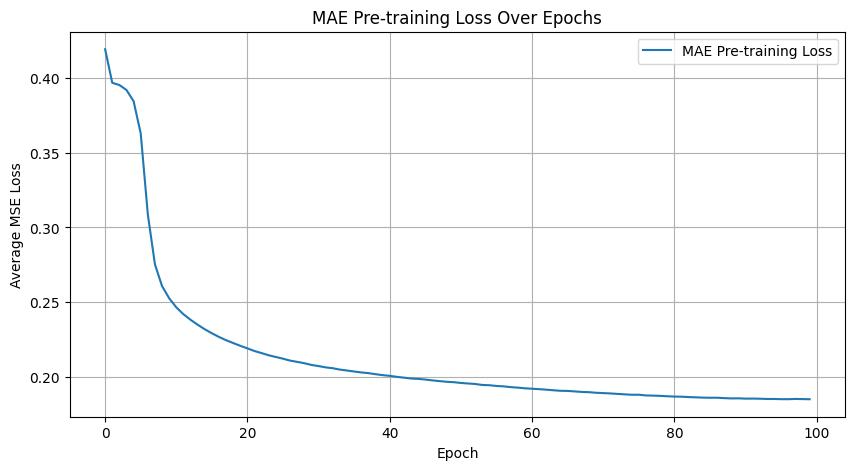

In [15]:
# Plot pretraining loss

plt.figure(figsize=(10, 5))
plt.plot(mae_losses, label='MAE Pre-training Loss')
plt.title('MAE Pre-training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# ----------------------------------------------------
# Fine-tune Spatio-Temporal Classifier
# ----------------------------------------------------

print("--- Starting Spatio-Temporal Fine-tuning ---")
clf = SpatioTemporalClassifier(
    img_size=(img_height, img_width), time_steps=img_depth,
    patch_size=patch_size_2d, in_channels=1, d_model=d_model,
    n_spatial_enc=n_spatial_enc, n_temporal_enc=n_temporal_enc,
    nhead_spatial=nhead_spatial, nhead_temporal=nhead_temporal,
    dropout=dropout, n_classes=num_classes
).to(device)

clf.patch_embed.load_state_dict(mae.patch_embed.state_dict())
clf.spatial_encoder.load_state_dict(mae.encoder.state_dict())
print("Weights from MAE's PatchEmbed and Spatial Encoder transferred to Classifier.")

opt_clf = optim.AdamW(clf.parameters(), lr=clf_lr, weight_decay=0.05)
sched_clf = optim.lr_scheduler.StepLR(opt_clf, step_size=int(clf_epochs * 0.7), gamma=0.1)
criterion = nn.CrossEntropyLoss()
# Instantiate a GradScaler for the fine-tuning loop
scaler_clf = GradScaler(enabled=(device.type == 'cuda'))

train_losses, test_losses = [], []
train_accs,  test_accs  = [], []
best_acc = 0.0

for ep in range(clf_epochs):
    # --- Train ---
    clf.train()
    running_loss = train_correct = train_total = 0
    pbar_train = tqdm(train_loader, desc=f"CLF Train Ep {ep+1}/{clf_epochs}")
    for imgs, labels in pbar_train:
        imgs, labels = imgs.to(device), labels.squeeze(1).to(device)
        opt_clf.zero_grad(set_to_none=True)
        # Use autocast for the forward pass
        with autocast(enabled=(device.type == "cuda")):
            logits = clf(imgs)
            loss = criterion(logits, labels)
        # Use scaler for backward pass and optimizer step
        scaler_clf.scale(loss).backward()
        scaler_clf.step(opt_clf)
        scaler_clf.update()

        running_loss += loss.item()
        train_correct += (logits.argmax(1) == labels).sum().item()
        train_total += labels.size(0)
        pbar_train.set_postfix(acc=100*train_correct/train_total)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * train_correct / train_total)
    sched_clf.step()

    # --- Validation ---
    clf.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        pbar_val = tqdm(test_loader, desc=f"CLF Val Ep {ep+1}/{clf_epochs}")
        for imgs, labels in pbar_val:
            imgs, labels = imgs.to(device), labels.squeeze(1).to(device)
            # Use autocast here as well for consistency, though it's not strictly necessary without a backward pass
            with autocast(enabled=(device.type == "cuda")):
                logits = clf(imgs)
                loss   = criterion(logits, labels)
            val_loss += loss.item()
            val_correct += (logits.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            pbar_val.set_postfix(acc=100*val_correct/val_total)

    test_losses.append(val_loss / len(test_loader))
    val_acc = 100 * val_correct / val_total
    test_accs.append(val_acc)


    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(clf.state_dict(), os.path.join(SAVE_DIR, "best_spatiotemporal_classifier.pt"))
        print(f"Epoch {ep+1} | New best accuracy: {best_acc:.2f}% | Model saved.")

    print(f"Epoch {ep+1}/{clf_epochs}: Train Acc {train_accs[-1]:.2f}% | Val Acc {val_acc:.2f}% (Best: {best_acc:.2f}%)")

print("\nFine-tuning complete.")

/tmp/ipython-input-16-575643134.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_clf = GradScaler(enabled=(device.type == 'cuda'))


--- Starting Spatio-Temporal Fine-tuning ---
Weights from MAE's PatchEmbed and Spatial Encoder transferred to Classifier.


CLF Train Ep 1/20:   0%|          | 0/440 [00:00<?, ?it/s]/tmp/ipython-input-16-575643134.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
CLF Val Ep 1/20:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipython-input-16-575643134.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
CLF Val Ep 1/20: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s, acc=83.8]


Epoch 1 | New best accuracy: 83.75% | Model saved.
Epoch 1/20: Train Acc 71.02% | Val Acc 83.75% (Best: 83.75%)


CLF Val Ep 2/20: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s, acc=85.9]


Epoch 2 | New best accuracy: 85.88% | Model saved.
Epoch 2/20: Train Acc 88.21% | Val Acc 85.88% (Best: 85.88%)


CLF Val Ep 3/20: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s, acc=85.1]


Epoch 3/20: Train Acc 90.48% | Val Acc 85.12% (Best: 85.88%)


CLF Val Ep 4/20: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s, acc=88]


Epoch 4 | New best accuracy: 88.00% | Model saved.
Epoch 4/20: Train Acc 91.73% | Val Acc 88.00% (Best: 88.00%)


CLF Val Ep 5/20: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s, acc=87.9]


Epoch 5/20: Train Acc 91.88% | Val Acc 87.88% (Best: 88.00%)


CLF Val Ep 6/20: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s, acc=89.4]


Epoch 6 | New best accuracy: 89.38% | Model saved.
Epoch 6/20: Train Acc 92.41% | Val Acc 89.38% (Best: 89.38%)


CLF Val Ep 7/20: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s, acc=87.2]


Epoch 7/20: Train Acc 93.95% | Val Acc 87.25% (Best: 89.38%)


CLF Val Ep 8/20: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s, acc=89.6]


Epoch 8 | New best accuracy: 89.62% | Model saved.
Epoch 8/20: Train Acc 93.55% | Val Acc 89.62% (Best: 89.62%)


CLF Val Ep 9/20: 100%|██████████| 100/100 [00:08<00:00, 12.07it/s, acc=90.1]


Epoch 9 | New best accuracy: 90.12% | Model saved.
Epoch 9/20: Train Acc 94.12% | Val Acc 90.12% (Best: 90.12%)


CLF Val Ep 10/20: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s, acc=90.6]


Epoch 10 | New best accuracy: 90.62% | Model saved.
Epoch 10/20: Train Acc 94.12% | Val Acc 90.62% (Best: 90.62%)


CLF Val Ep 11/20: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s, acc=90.9]


Epoch 11 | New best accuracy: 90.88% | Model saved.
Epoch 11/20: Train Acc 94.69% | Val Acc 90.88% (Best: 90.88%)


CLF Val Ep 12/20: 100%|██████████| 100/100 [00:08<00:00, 11.31it/s, acc=88.5]


Epoch 12/20: Train Acc 94.74% | Val Acc 88.50% (Best: 90.88%)


CLF Val Ep 13/20: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s, acc=88.8]


Epoch 13/20: Train Acc 94.72% | Val Acc 88.75% (Best: 90.88%)


CLF Val Ep 14/20: 100%|██████████| 100/100 [00:08<00:00, 12.11it/s, acc=88.2]


Epoch 14/20: Train Acc 96.19% | Val Acc 88.25% (Best: 90.88%)


CLF Val Ep 15/20: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s, acc=90]


Epoch 15/20: Train Acc 98.07% | Val Acc 90.00% (Best: 90.88%)


CLF Val Ep 16/20: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s, acc=90.1]


Epoch 16/20: Train Acc 98.52% | Val Acc 90.12% (Best: 90.88%)


CLF Val Ep 17/20: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s, acc=90.4]


Epoch 17/20: Train Acc 98.69% | Val Acc 90.38% (Best: 90.88%)


CLF Val Ep 18/20: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s, acc=89.9]


Epoch 18/20: Train Acc 99.20% | Val Acc 89.88% (Best: 90.88%)


CLF Val Ep 19/20: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s, acc=90.6]


Epoch 19/20: Train Acc 99.23% | Val Acc 90.62% (Best: 90.88%)


CLF Val Ep 20/20: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s, acc=90]

Epoch 20/20: Train Acc 99.32% | Val Acc 90.00% (Best: 90.88%)

Fine-tuning complete.


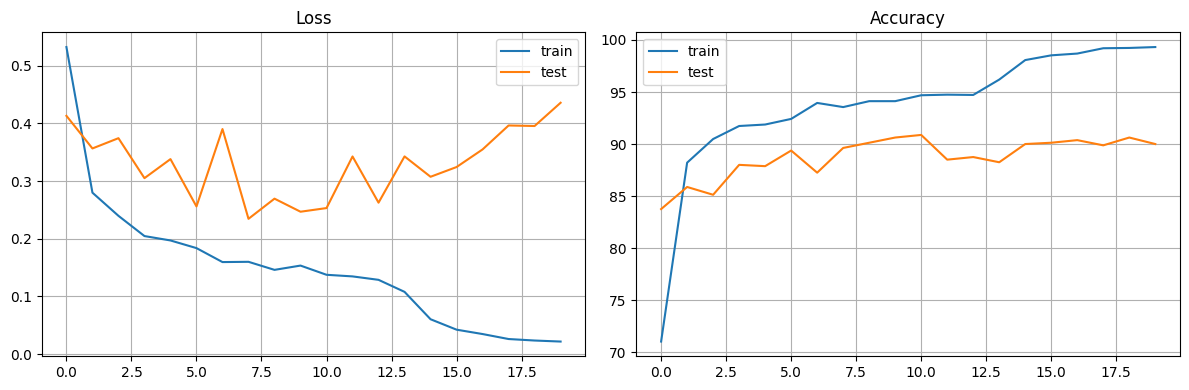

In [17]:
# ----------------------------------------------------
# Plot Finetuning metrices
# ----------------------------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.title('Loss'); plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(train_accs,label='train')
plt.plot(test_accs,label='test')
plt.title('Accuracy'); plt.legend(); plt.grid()

plt.tight_layout()
plt.show()


--- Final Evaluation on Test Set ---


Evaluating best model:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipython-input-22-899610738.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Evaluating best model: 100%|██████████| 100/100 [00:11<00:00,  8.58it/s]



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.97      0.91       400
     Class 1       0.96      0.85      0.90       400

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800


Confusion Matrix:


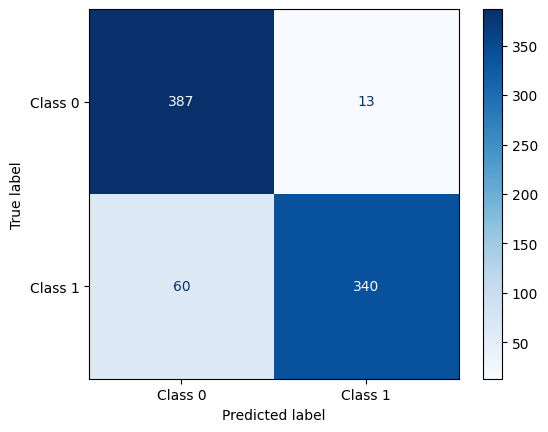

In [22]:
# ----------------------------------------------------
# Final Evaluation
# ----------------------------------------------------
print("\n--- Final Evaluation on Test Set ---")
# Load the best performing model
clf.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_spatiotemporal_classifier.pt")))
clf.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating best model"):
        imgs = imgs.to(device)
        labels = labels.squeeze(1)

        with autocast(enabled=(device.type == "cuda")):
            logits = clf(imgs)

        all_preds.append(logits.argmax(1).cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

# Display Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.show()